<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os


def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Vanishing/Exploding Gradients Problem

In [3]:
def logit(z):
    return 1/(1+np.exp(-z))

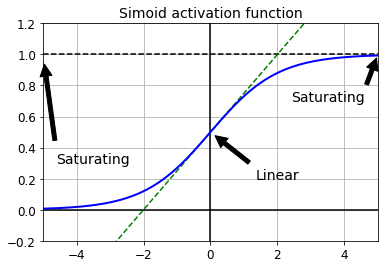

In [4]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), 'b-', linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1),
             arrowprops=props, fontsize=14, ha='center')
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 1),
             arrowprops=props, fontsize=14, ha='center')
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5),
             arrowprops=props, fontsize=14, ha='center')
plt.grid(True)
plt.title('Simoid activation function', fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

Xavier and He Initialization
Note: the book uses tensorflow.contrib.layers.fully_connected() rather than tf.layers.dense() (which did not exist when this chapter was written). It is now preferable to use tf.layers.dense(), because anything in the contrib module may change or be deleted without notice. The dense() function is almost identical to the fully_connected() function. The main differences relevant to this chapter are:

several parameters are renamed: scope becomes name, activation_fn becomes activation (and similarly the _fn suffix is removed from other parameters such as normalizer_fn), weights_initializer becomes kernel_initializer, etc.
the default activation is now None rather than tf.nn.relu.
it does not support tensorflow.contrib.framework.arg_scope() (introduced later in chapter 11).
it does not support regularizer params (introduced later in chapter 11).

In [5]:
import tensorflow as tf 

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_hidden1), name='X')

In [7]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name='hidden1')

Nonsaturating Activation Functions

In [9]:
def leaky_relu(z,alpha =0.01):
    return np.maximum(alpha*z,z)

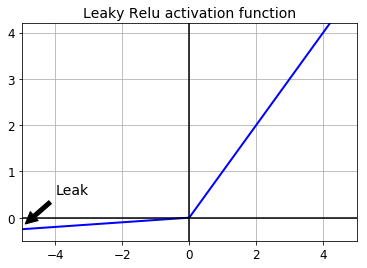

In [12]:
plt.plot(z, leaky_relu(z, 0.05), 'b-', linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2),
             arrowprops=props, fontsize=14, ha='center')
plt.title('Leaky Relu activation function', fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [14]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')

In [26]:
def leaky_relu(z,name=None):
    return tf.maximum(0.01*z,z,name=name)

# hidden1 = tf.layers.dense(X,n_hidden1,activation=leafy_relu,name = 'hidden1')

In [27]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [28]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

In [29]:
with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(
        X, n_hidden1, activation=leaky_relu, name='hidden1')
    hidden2 = tf.layers.dense(
        hidden1, n_hidden2, activation=leaky_relu, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, name='logit')

In [30]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

In [31]:
learning_rate = 0.01

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [32]:
with tf.name_scope('eva'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [33]:
init = tf.global_variables_initializer()

In [37]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28)/255.00
X_test = X_test.astype(np.float32).reshape(-1, 28*28)/255.00
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [48]:
def shuffle_batch(X, y, batch_size):
    rnd_inx = np.random.permutation(len(X))
    n_batches = len(X)//batch_size
    for batch_idx in np.array_split(rnd_inx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
#     return X_batch, y_batch

In [49]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, 'Batch accuracy:', acc_batch,
                  'Validation accuracy:', acc_valid)

0 Batch accuracy: 0.94 Validation accuracy: 0.9024
5 Batch accuracy: 0.9 Validation accuracy: 0.9508
10 Batch accuracy: 0.92 Validation accuracy: 0.965
15 Batch accuracy: 1.0 Validation accuracy: 0.9718
20 Batch accuracy: 1.0 Validation accuracy: 0.9756
25 Batch accuracy: 0.98 Validation accuracy: 0.9762
30 Batch accuracy: 0.98 Validation accuracy: 0.9782
35 Batch accuracy: 1.0 Validation accuracy: 0.9798


ELU

In [52]:
def elu(z,alpha = 1):
    return np.where(z<0,alpha*(np.exp(z)-1),z)

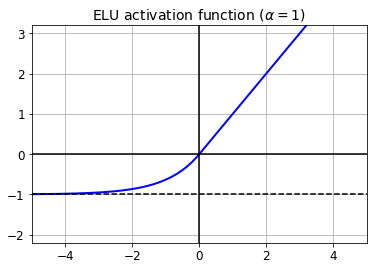

In [53]:
plt.plot(z, elu(z), 'b-', linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r'ELU activation function ($\alpha = 1$)', fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

SELU

In [54]:
def selu(z,
        scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale*elu(z,alpha)

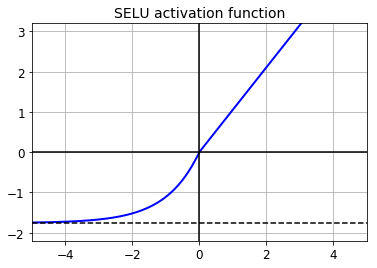

In [57]:
plt.plot(z,selu(z),'b-',linewidth=2)
plt.plot([-5,5],[0,0],'k-')
plt.plot([-5,5],[-1.758,-1.758],'k--')
plt.plot([0,0],[-2.2,3.2],'k-')
plt.grid(True)
plt.title(r'SELU activation function',fontsize =14)
plt.axis([-5,5,-2.2,3.2])
plt.show()

In [62]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print('layer {}:{:.2f}<mean<{:.2f},{:.2f}<stds <{:.2f}'.format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

layer 0:-0.26<mean<0.27,0.74<stds <1.27
layer 10:-0.24<mean<0.27,0.74<stds <1.27
layer 20:-0.17<mean<0.18,0.74<stds <1.24
layer 30:-0.27<mean<0.24,0.78<stds <1.20
layer 40:-0.38<mean<0.39,0.74<stds <1.25
layer 50:-0.27<mean<0.31,0.73<stds <1.27
layer 60:-0.26<mean<0.43,0.74<stds <1.35
layer 70:-0.19<mean<0.21,0.75<stds <1.21
layer 80:-0.18<mean<0.16,0.72<stds <1.19
layer 90:-0.19<mean<0.16,0.75<stds <1.20


In [67]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha*tf.nn.elu(z))

In [73]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name='hidden1')
    hidden2 = tf.layers.dense(
        hidden1, n_hidden2, activation=selu, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, name='output')
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

learning_rate = 0.01

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
n_epochs = 40
batch_size = 50

In [74]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True)+1e-10
X_val_scaled = (X_valid-means)/stds

n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch-means)/stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(
                feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(
                feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, 'Batch accuracy:', acc_batch,
                  'Validation accuracy:', acc_valid)

0 Batch accuracy: 0.88 Validation accuracy: 0.9232
5 Batch accuracy: 0.98 Validation accuracy: 0.9574
10 Batch accuracy: 1.0 Validation accuracy: 0.9662
15 Batch accuracy: 0.96 Validation accuracy: 0.9684
20 Batch accuracy: 1.0 Validation accuracy: 0.9692
25 Batch accuracy: 1.0 Validation accuracy: 0.969
30 Batch accuracy: 1.0 Validation accuracy: 0.9694
35 Batch accuracy: 1.0 Validation accuracy: 0.9702


`Batch Normalization

In [77]:
import tensorflow as tf
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1')
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name='hidden2')
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name='outputs')
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum = 0.9)